STEP 1: DATA IMPORT & CLEANING

1. Loading dataset...
   Initial dataset shape: (52336, 16)
   Columns: ['date', 'admin1', 'admin2', 'market', 'market_id', 'latitude', 'longitude', 'category', 'commodity', 'commodity_id', 'unit', 'priceflag', 'pricetype', 'currency', 'price', 'usdprice']

2. Initial data exploration:
   Data types:
date             object
admin1           object
admin2           object
market           object
market_id         int64
latitude        float64
longitude       float64
category         object
commodity        object
commodity_id      int64
unit             object
priceflag        object
pricetype        object
currency         object
price           float64
usdprice        float64
dtype: object

   Missing values:
date            0
admin1          0
admin2          0
market          0
market_id       0
latitude        0
longitude       0
category        0
commodity       0
commodity_id    0
unit            0
priceflag       0
pricetype       0
currency      

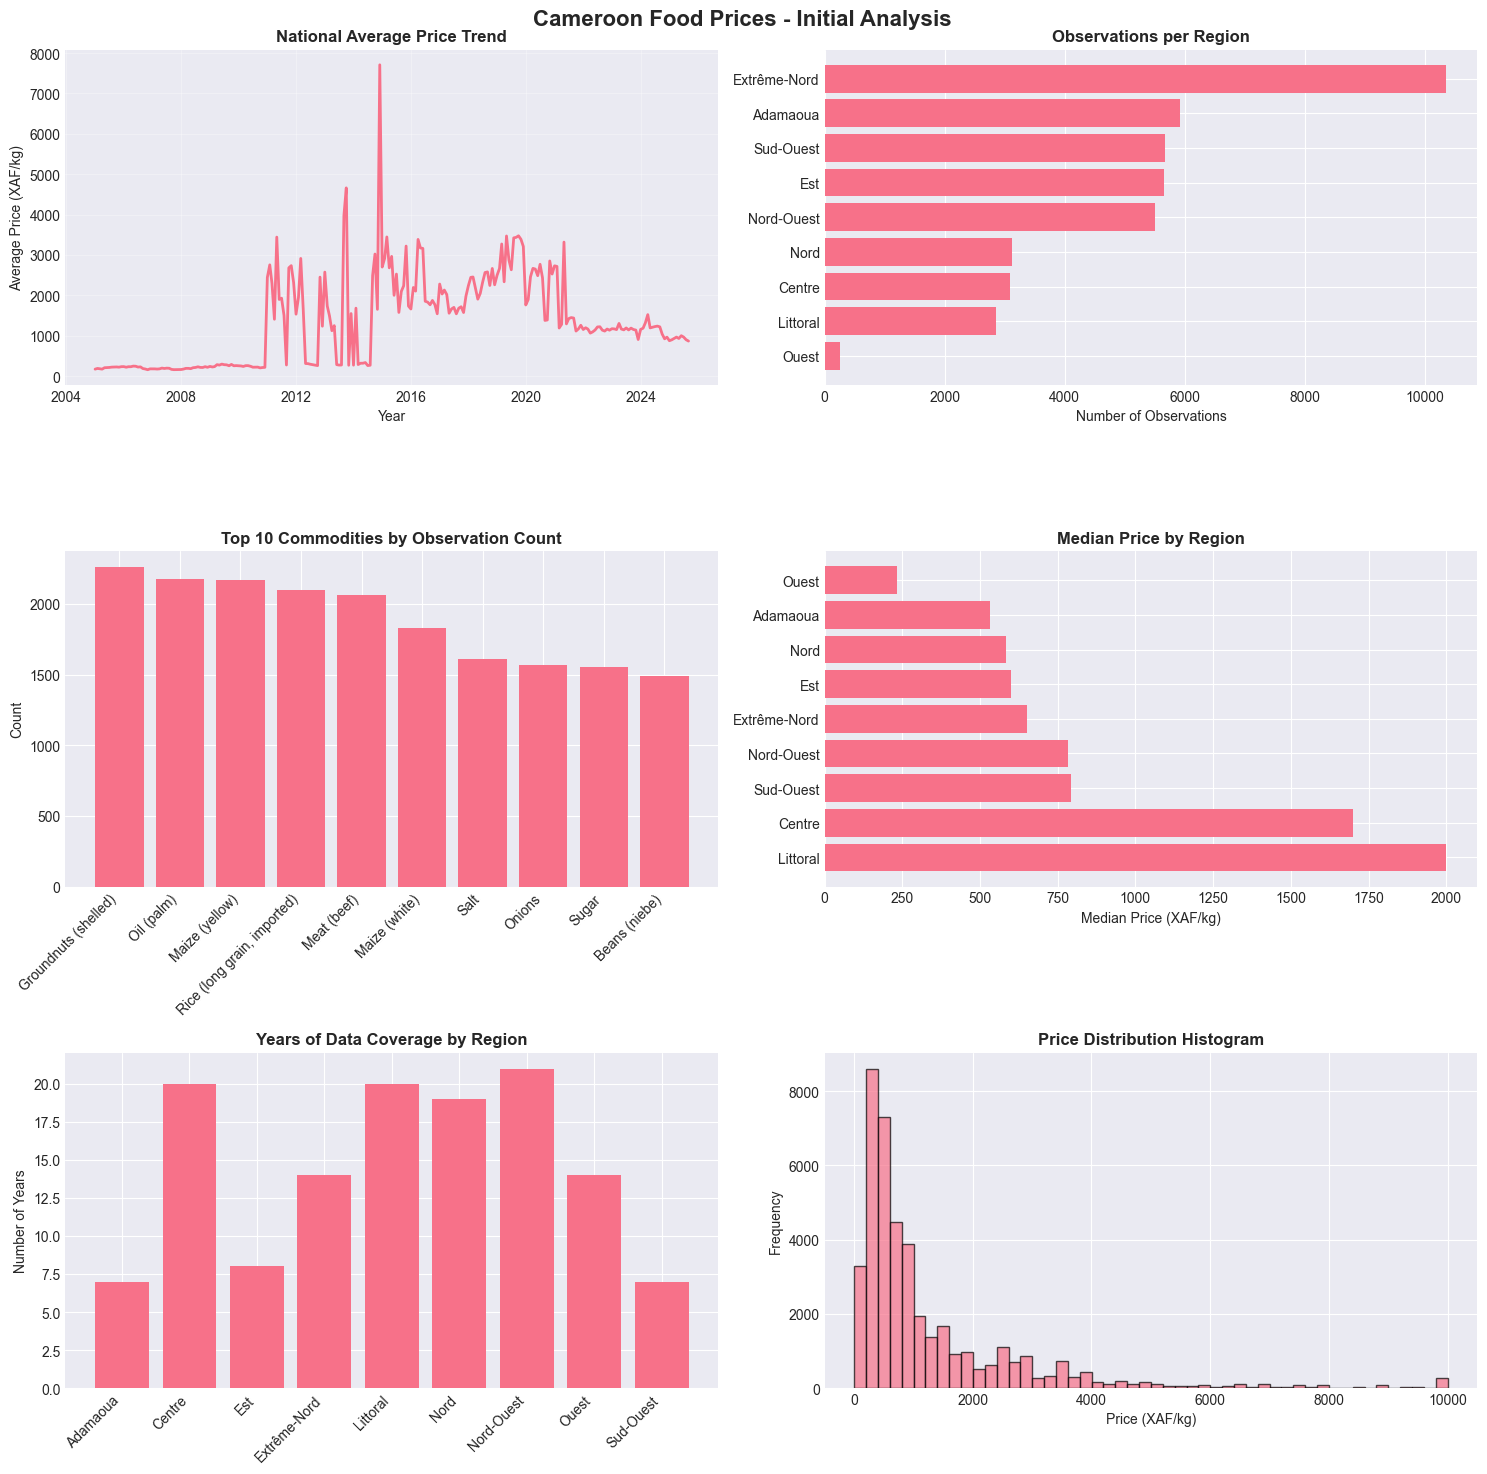


STEP 1 COMPLETED SUCCESSFULLY


In [1]:
# Step 1: Data Import & Cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("STEP 1: DATA IMPORT & CLEANING")
print("=" * 80)

# Load the CSV file, skipping the metadata row (second row)
print("\n1. Loading dataset...")
df = pd.read_csv('wfp_food_prices_cmr (3).csv', skiprows=[1])  # Skip the metadata row

print(f"   Initial dataset shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")

# Display initial info
print("\n2. Initial data exploration:")
print(f"   Data types:\n{df.dtypes}")
print(f"\n   Missing values:\n{df.isnull().sum()}")

# Parse date column
print("\n3. Parsing dates...")
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

# Check for missing values
print("\n4. Handling missing values...")
missing_before = df.isnull().sum().sum()
print(f"   Total missing values before cleaning: {missing_before}")

# Drop rows with critical missing values
df_clean = df.dropna(subset=['date', 'price', 'commodity', 'admin1'])

# Fill other missing values if needed
for col in ['admin2', 'market', 'unit']:
    if df_clean[col].isnull().any():
        df_clean[col] = df_clean[col].fillna('Unknown')

missing_after = df_clean.isnull().sum().sum()
print(f"   Total missing values after cleaning: {missing_after}")

# Standardize prices to XAF per kg
print("\n5. Standardizing prices to XAF per kg...")

def standardize_price(row):
    """
    Convert all prices to XAF per kg
    """
    price = float(row['price'])
    unit = str(row['unit']).lower()
    
    # Handle different units
    if 'kg' in unit:
        # Already per kg
        return price
    elif '90' in unit:
        # 90kg bag
        return price / 90
    elif '50' in unit:
        # 50kg bag
        return price / 50
    elif '100' in unit:
        # 100kg bag
        return price / 100
    else:
        # Assume per kg if unknown
        return price

# Apply standardization
df_clean['price_per_kg'] = df_clean.apply(standardize_price, axis=1)

# Remove extreme outliers
print("\n6. Removing extreme outliers...")
print(f"   Price range before outlier removal: [{df_clean['price_per_kg'].min():.2f}, {df_clean['price_per_kg'].max():.2f}]")

# Define reasonable price range (1 to 10000 XAF per kg)
df_clean = df_clean[(df_clean['price_per_kg'] >= 1) & (df_clean['price_per_kg'] <= 10000)]

print(f"   Price range after outlier removal: [{df_clean['price_per_kg'].min():.2f}, {df_clean['price_per_kg'].max():.2f}]")

# Save cleaned data
print("\n7. Saving cleaned data...")
df_clean.to_csv('cleaned_food_prices.csv', index=False)
print("   Saved as 'cleaned_food_prices.csv'")

# Summary statistics
print("\n8. Summary statistics:")
print(f"   Final dataset shape: {df_clean.shape}")
print(f"\n   Price statistics (XAF per kg):")
price_stats = df_clean['price_per_kg'].describe()
print(price_stats)

print(f"\n   Unique regions: {df_clean['admin1'].nunique()}")
print(f"   Unique commodities: {df_clean['commodity'].nunique()}")
print(f"   Unique categories: {df_clean['category'].nunique()}")

# Top 10 commodities by count
print("\n9. Top 10 commodities by observation count:")
top_commodities = df_clean['commodity'].value_counts().head(10)
print(top_commodities)

# Visualizations
print("\n10. Creating visualizations...")

# Set up figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Cameroon Food Prices - Initial Analysis', fontsize=16, fontweight='bold')

# 1. National average price trend
national_avg = df_clean.groupby(df_clean['date'].dt.to_period('M'))['price_per_kg'].mean()
national_avg.index = national_avg.index.to_timestamp()

axes[0, 0].plot(national_avg.index, national_avg.values, linewidth=2)
axes[0, 0].set_title('National Average Price Trend', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Average Price (XAF/kg)')
axes[0, 0].grid(True, alpha=0.3)

# 2. Observations per region
region_counts = df_clean['admin1'].value_counts()
axes[0, 1].barh(range(len(region_counts)), region_counts.values)
axes[0, 1].set_yticks(range(len(region_counts)))
axes[0, 1].set_yticklabels(region_counts.index)
axes[0, 1].set_title('Observations per Region', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Observations')
axes[0, 1].invert_yaxis()

# 3. Top commodities bar chart
axes[1, 0].bar(range(len(top_commodities)), top_commodities.values)
axes[1, 0].set_xticks(range(len(top_commodities)))
axes[1, 0].set_xticklabels(top_commodities.index, rotation=45, ha='right')
axes[1, 0].set_title('Top 10 Commodities by Observation Count', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Count')

# 4. Price distribution by region
price_by_region = df_clean.groupby('admin1')['price_per_kg'].median().sort_values()
axes[1, 1].barh(range(len(price_by_region)), price_by_region.values)
axes[1, 1].set_yticks(range(len(price_by_region)))
axes[1, 1].set_yticklabels(price_by_region.index)
axes[1, 1].set_title('Median Price by Region', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Median Price (XAF/kg)')
axes[1, 1].invert_yaxis()

# 5. Time coverage by region
coverage = df_clean.groupby('admin1')['year'].nunique()
axes[2, 0].bar(range(len(coverage)), coverage.values)
axes[2, 0].set_xticks(range(len(coverage)))
axes[2, 0].set_xticklabels(coverage.index, rotation=45, ha='right')
axes[2, 0].set_title('Years of Data Coverage by Region', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Number of Years')

# 6. Price distribution histogram
axes[2, 1].hist(df_clean['price_per_kg'], bins=50, edgecolor='black', alpha=0.7)
axes[2, 1].set_title('Price Distribution Histogram', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Price (XAF/kg)')
axes[2, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('step1_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("STEP 1 COMPLETED SUCCESSFULLY")
print("=" * 80)


STEP 2: IDENTIFY HIGHEST UNIQUE COMMODITY PER REGION

1. Analyzing commodity distribution by region...

   Total region-commodity combinations: 273

2. Selecting unique highest commodity per region...

3. Selected commodities per region:
      Region              Commodity  Count
      Centre             Oil (palm)    340
    Littoral   Groundnuts (shelled)    313
        Nord          Maize (white)    284
  Nord-Ouest         Maize (yellow)    634
       Ouest                   Rice      8
Extrême-Nord                 Onions    517
         Est                   Salt    352
    Adamaoua            Meat (beef)    307
   Sud-Ouest Fish (mackerel, fresh)    337

   Saved selection as 'region_commodity_selection.csv'

4. Creating visualizations...


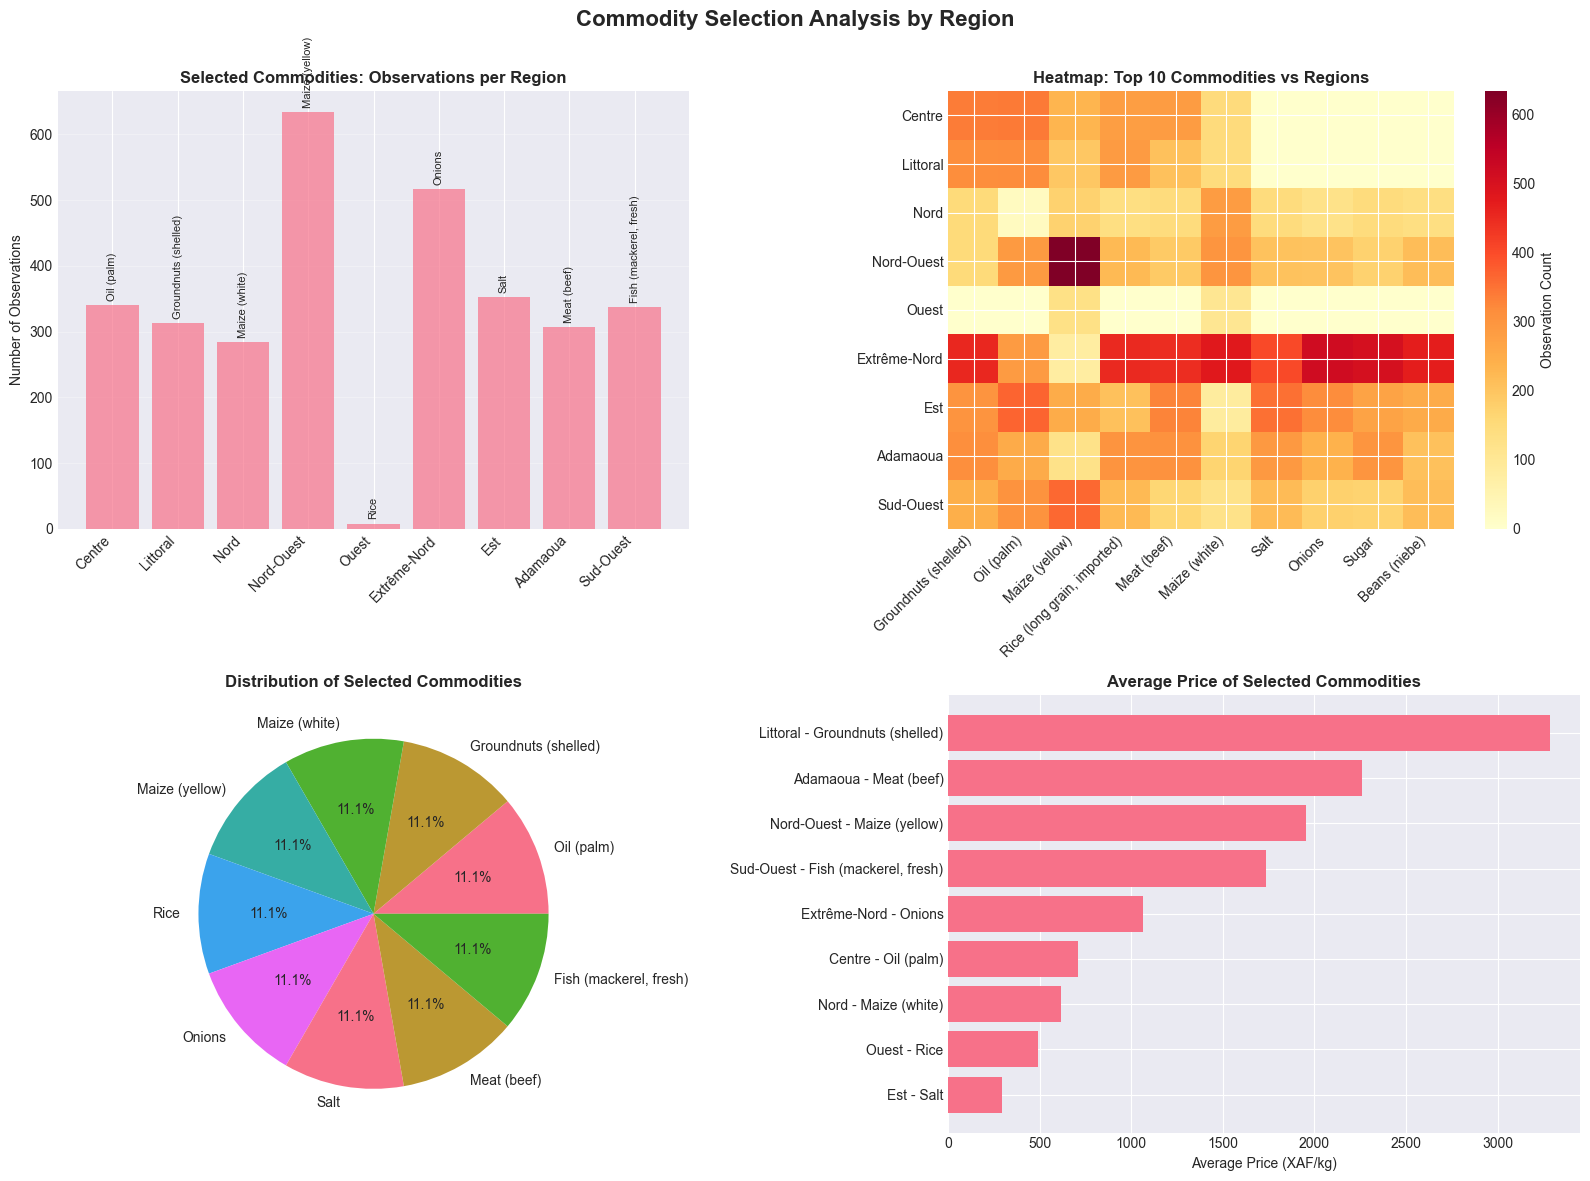


STEP 2 COMPLETED SUCCESSFULLY


In [2]:
# Step 2: Identify Highest Unique Commodity per Region
print("\n" + "=" * 80)
print("STEP 2: IDENTIFY HIGHEST UNIQUE COMMODITY PER REGION")
print("=" * 80)

print("\n1. Analyzing commodity distribution by region...")

# Group by region and commodity to count observations
region_commodity_counts = df_clean.groupby(['admin1', 'commodity']).size().reset_index(name='count')
region_commodity_counts = region_commodity_counts.sort_values(['admin1', 'count'], ascending=[True, False])

print(f"\n   Total region-commodity combinations: {len(region_commodity_counts)}")

# Select unique highest commodity per region
print("\n2. Selecting unique highest commodity per region...")
selected_commodities = {}
all_regions = df_clean['admin1'].unique()

for region in all_regions:
    region_data = region_commodity_counts[region_commodity_counts['admin1'] == region]
    
    for _, row in region_data.iterrows():
        commodity = row['commodity']
        count = row['count']
        
        # Check if commodity is already selected for another region
        if commodity not in selected_commodities.values():
            selected_commodities[region] = commodity
            break
    
    # If no unique commodity found (shouldn't happen with our data), pick the first one
    if region not in selected_commodities:
        selected_commodities[region] = region_data.iloc[0]['commodity']

# Create summary table
summary_table = []
for region, commodity in selected_commodities.items():
    count = region_commodity_counts[
        (region_commodity_counts['admin1'] == region) & 
        (region_commodity_counts['commodity'] == commodity)
    ]['count'].values[0]
    summary_table.append({'Region': region, 'Commodity': commodity, 'Count': count})

summary_df = pd.DataFrame(summary_table)
print("\n3. Selected commodities per region:")
print(summary_df.to_string(index=False))

# Save the summary table
summary_df.to_csv('region_commodity_selection.csv', index=False)
print("\n   Saved selection as 'region_commodity_selection.csv'")

# Visualizations
print("\n4. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Commodity Selection Analysis by Region', fontsize=16, fontweight='bold')

# 1. Bar chart of selected commodities per region
regions = list(selected_commodities.keys())
commodities = list(selected_commodities.values())
counts = [row['Count'] for row in summary_table]

x_pos = np.arange(len(regions))
axes[0, 0].bar(x_pos, counts, alpha=0.7)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(regions, rotation=45, ha='right')
axes[0, 0].set_title('Selected Commodities: Observations per Region', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Observations')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add commodity labels on bars
for i, (commodity, count) in enumerate(zip(commodities, counts)):
    axes[0, 0].text(i, count + max(counts)*0.01, commodity, 
                   rotation=90, ha='center', va='bottom', fontsize=8)

# 2. Heatmap of top 10 commodities vs regions
top_10_commodities = df_clean['commodity'].value_counts().head(10).index.tolist()

# Create pivot table for heatmap
heatmap_data = pd.DataFrame(index=all_regions, columns=top_10_commodities)
for region in all_regions:
    region_data = df_clean[df_clean['admin1'] == region]
    commodity_counts = region_data['commodity'].value_counts()
    for commodity in top_10_commodities:
        heatmap_data.loc[region, commodity] = commodity_counts.get(commodity, 0)

# Convert to numeric
heatmap_data = heatmap_data.astype(float)

im = axes[0, 1].imshow(heatmap_data.values, aspect='auto', cmap='YlOrRd')
axes[0, 1].set_title('Heatmap: Top 10 Commodities vs Regions', fontsize=12, fontweight='bold')
axes[0, 1].set_yticks(range(len(all_regions)))
axes[0, 1].set_yticklabels(all_regions)
axes[0, 1].set_xticks(range(len(top_10_commodities)))
axes[0, 1].set_xticklabels(top_10_commodities, rotation=45, ha='right')
plt.colorbar(im, ax=axes[0, 1], label='Observation Count')

# 3. Pie chart of commodity distribution
commodity_dist = summary_df['Commodity'].value_counts()
axes[1, 0].pie(commodity_dist.values, labels=commodity_dist.index, autopct='%1.1f%%')
axes[1, 0].set_title('Distribution of Selected Commodities', fontsize=12, fontweight='bold')

# 4. Average price of selected commodities
avg_prices = []
for _, row in summary_df.iterrows():
    avg_price = df_clean[
        (df_clean['admin1'] == row['Region']) & 
        (df_clean['commodity'] == row['Commodity'])
    ]['price_per_kg'].mean()
    avg_prices.append(avg_price)

summary_df['Avg_Price'] = avg_prices
sorted_df = summary_df.sort_values('Avg_Price', ascending=False)

axes[1, 1].barh(range(len(sorted_df)), sorted_df['Avg_Price'].values)
axes[1, 1].set_yticks(range(len(sorted_df)))
axes[1, 1].set_yticklabels([f"{r} - {c}" for r, c in zip(sorted_df['Region'], sorted_df['Commodity'])])
axes[1, 1].set_title('Average Price of Selected Commodities', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Price (XAF/kg)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('step2_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("STEP 2 COMPLETED SUCCESSFULLY")
print("=" * 80)


STEP 3: INDIVIDUAL MODELING PER REGION-COMMODITY PAIR

Starting individual modeling for each region-commodity pair...
--------------------------------------------------------------------------------

MODELING: Centre - Oil (palm)
   Total observations: 340
   Monthly observations: 115
   Date range: 2015-01-31 00:00:00 to 2024-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 735.34
     Std: 469.00
     Min: 500.00
     Max: 5375.00

   Creating features...
   Train samples: 72 (2016-01-31 00:00:00 to 2022-01-31 00:00:00)
   Validation samples: 15 (2022-02-28 00:00:00 to 2023-04-30 00:00:00)
   Test samples: 16 (2023-05-31 00:00:00 to 2024-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 72)
   Training XGBoost...
   Training CatBoost...
   Trainin

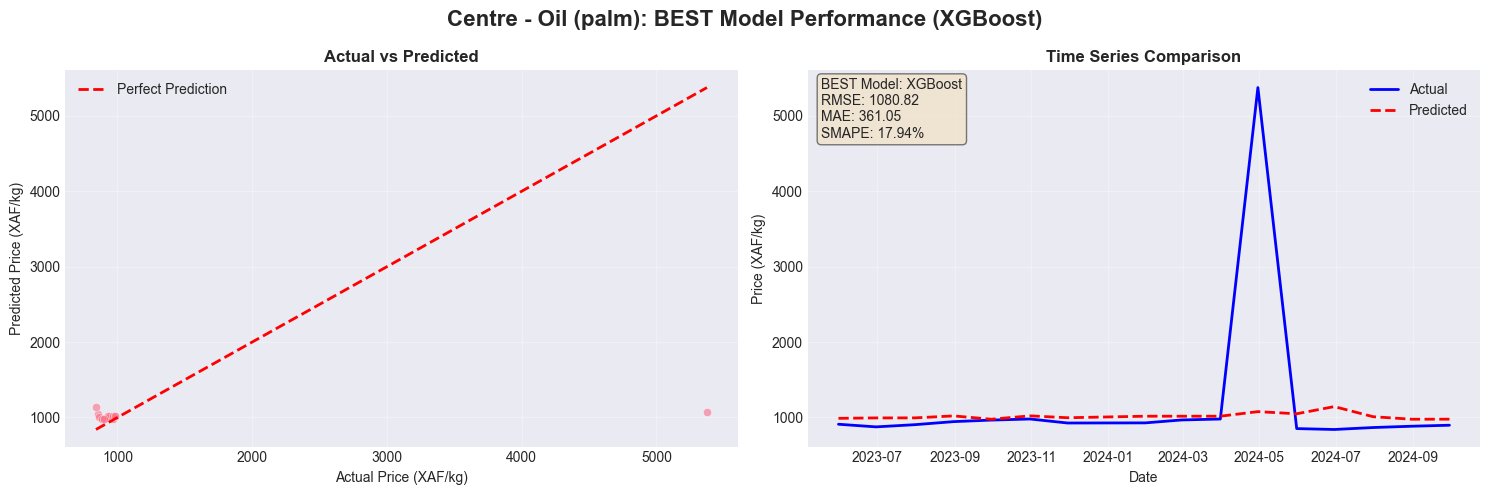


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: XGBoost
   Completed modeling for Centre - Oil (palm)


MODELING: Littoral - Groundnuts (shelled)
   Total observations: 313
   Monthly observations: 116
   Date range: 2015-01-31 00:00:00 to 2024-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 3325.33
     Std: 814.73
     Min: 541.33
     Max: 5200.00

   Creating features...
   Train samples: 72 (2016-01-31 00:00:00 to 2021-12-31 00:00:00)
   Validation samples: 15 (2022-01-31 00:00:00 to 2023-03-31 00:00:00)
   Test samples: 17 (2023-04-30 00:00:00 to 2024-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 72)
   Training XGBoost...
   Training CatBoost...
   Traini

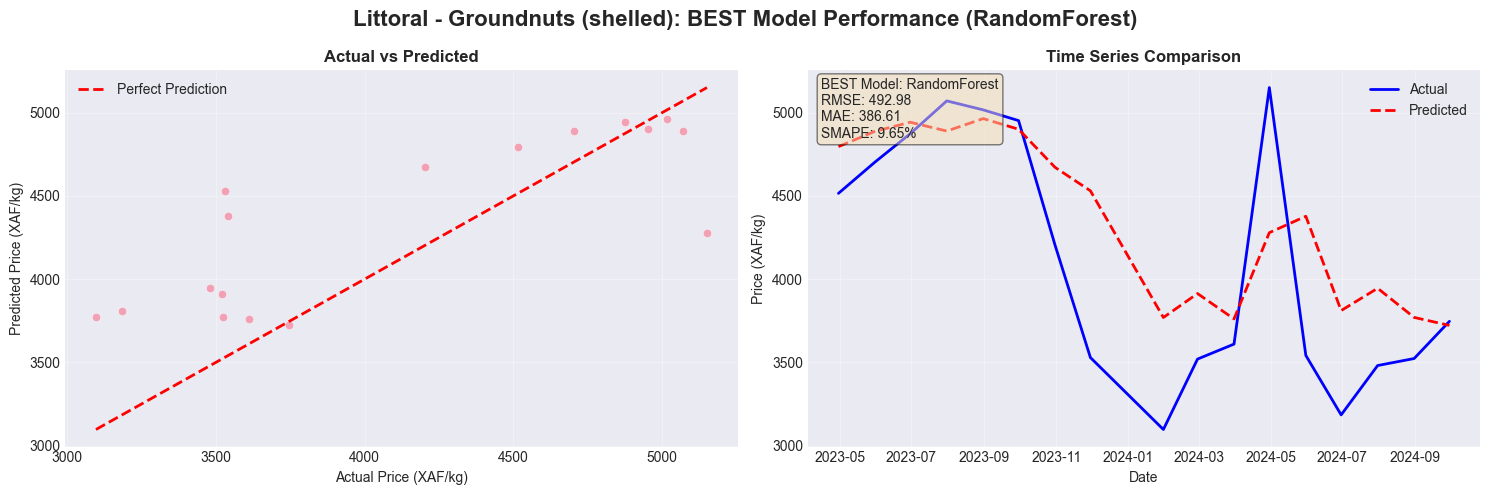


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: RandomForest
   Completed modeling for Littoral - Groundnuts (shelled)


MODELING: Nord - Maize (white)
   Total observations: 284
   Monthly observations: 176
   Date range: 2005-01-31 00:00:00 to 2025-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 443.47
     Std: 1269.48
     Min: 122.81
     Max: 10000.00

   Creating features...
   Train samples: 114 (2006-04-30 00:00:00 to 2020-04-30 00:00:00)
   Validation samples: 24 (2020-05-31 00:00:00 to 2023-06-30 00:00:00)
   Test samples: 26 (2023-07-31 00:00:00 to 2025-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 114)
   Training XGBoost...
   Training CatBoost...


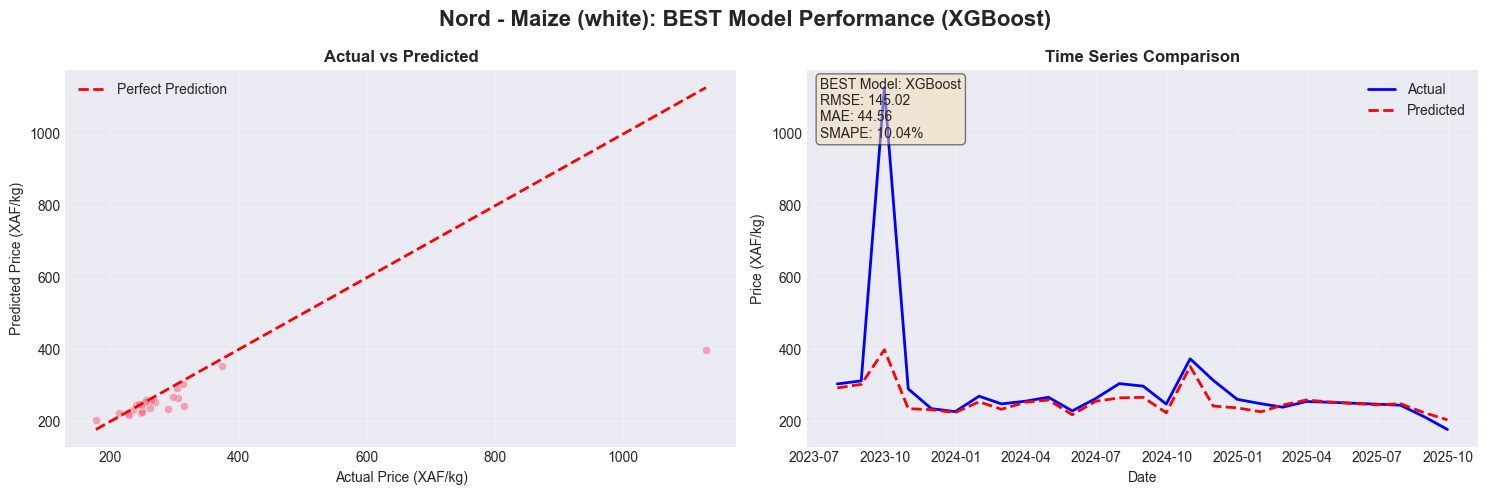


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: XGBoost
   Completed modeling for Nord - Maize (white)


MODELING: Nord-Ouest - Maize (yellow)
   Total observations: 634
   Monthly observations: 201
   Date range: 2005-01-31 00:00:00 to 2025-08-31 00:00:00
   Price statistics (XAF/kg):
     Mean: 1434.60
     Std: 1347.43
     Min: 134.49
     Max: 4681.25

   Creating features...
   Train samples: 132 (2006-08-31 00:00:00 to 2020-09-30 00:00:00)
   Validation samples: 28 (2020-10-31 00:00:00 to 2023-01-31 00:00:00)
   Test samples: 29 (2023-02-28 00:00:00 to 2025-08-31 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 132)
   Training XGBoost...
   Training CatBoost...
   Traini

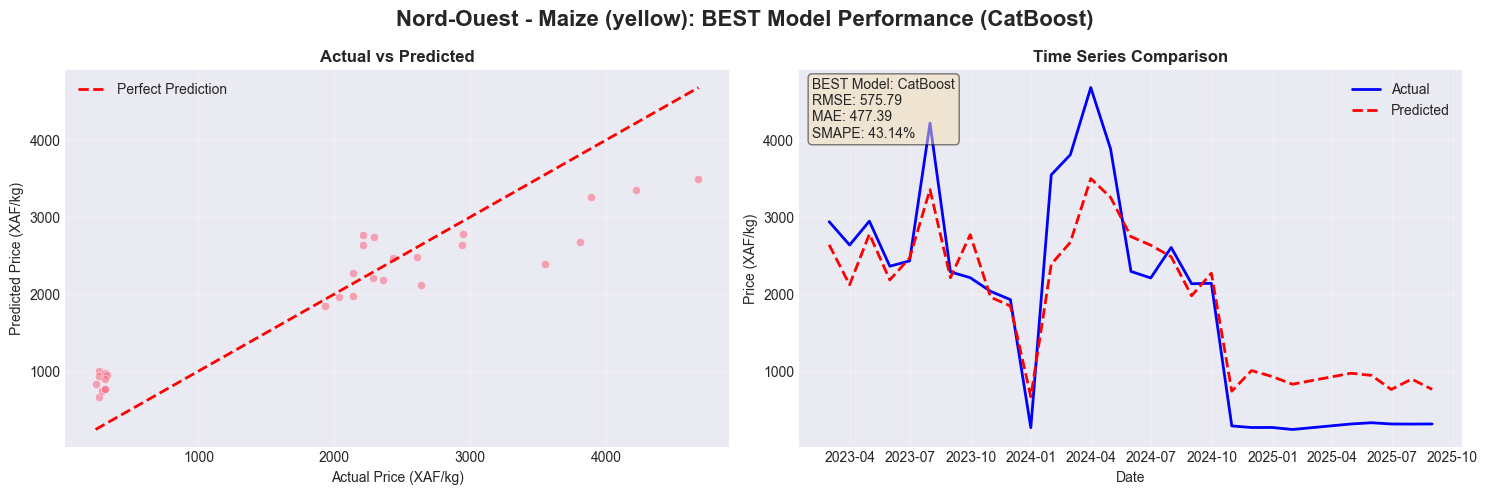


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: CatBoost
   Completed modeling for Nord-Ouest - Maize (yellow)


MODELING: Ouest - Rice
   Total observations: 8
   SKIPPING: Insufficient data (minimum 30 observations required)

MODELING: Extrême-Nord - Onions
   Total observations: 517
   Monthly observations: 74
   Date range: 2012-03-31 00:00:00 to 2025-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 2648.12
     Std: 3541.45
     Min: 282.82
     Max: 10000.00

   Creating features...
   Train samples: 43 (2018-03-31 00:00:00 to 2024-02-29 00:00:00)
   Validation samples: 9 (2024-03-31 00:00:00 to 2024-11-30 00:00:00)
   Test samples: 10 (2024-12-31 00:00:00 to 2025-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained s

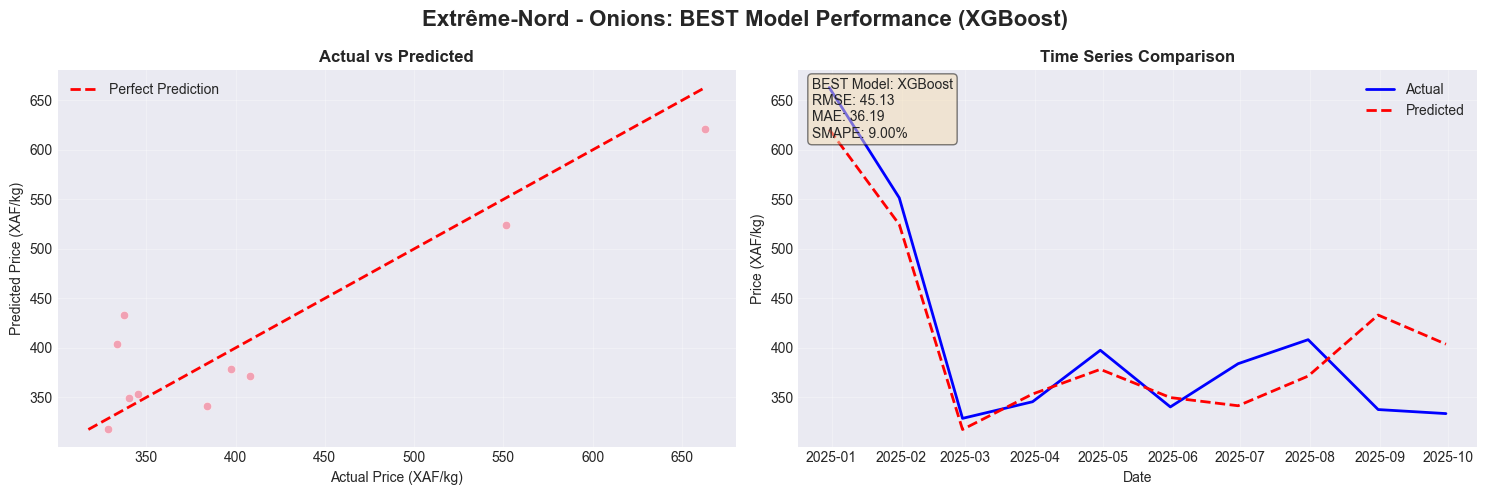


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: XGBoost
   Completed modeling for Extrême-Nord - Onions


MODELING: Est - Salt
   Total observations: 352
   Monthly observations: 54
   Date range: 2020-09-30 00:00:00 to 2025-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 295.32
     Std: 26.95
     Min: 211.11
     Max: 353.40

   Creating features...
   Train samples: 29 (2022-03-31 00:00:00 to 2024-07-31 00:00:00)
   Validation samples: 6 (2024-09-30 00:00:00 to 2025-02-28 00:00:00)
   Test samples: 7 (2025-03-31 00:00:00 to 2025-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 29)
   Training XGBoost...
   Training CatBoost...
   Training LSTM...
   LSTM skippe

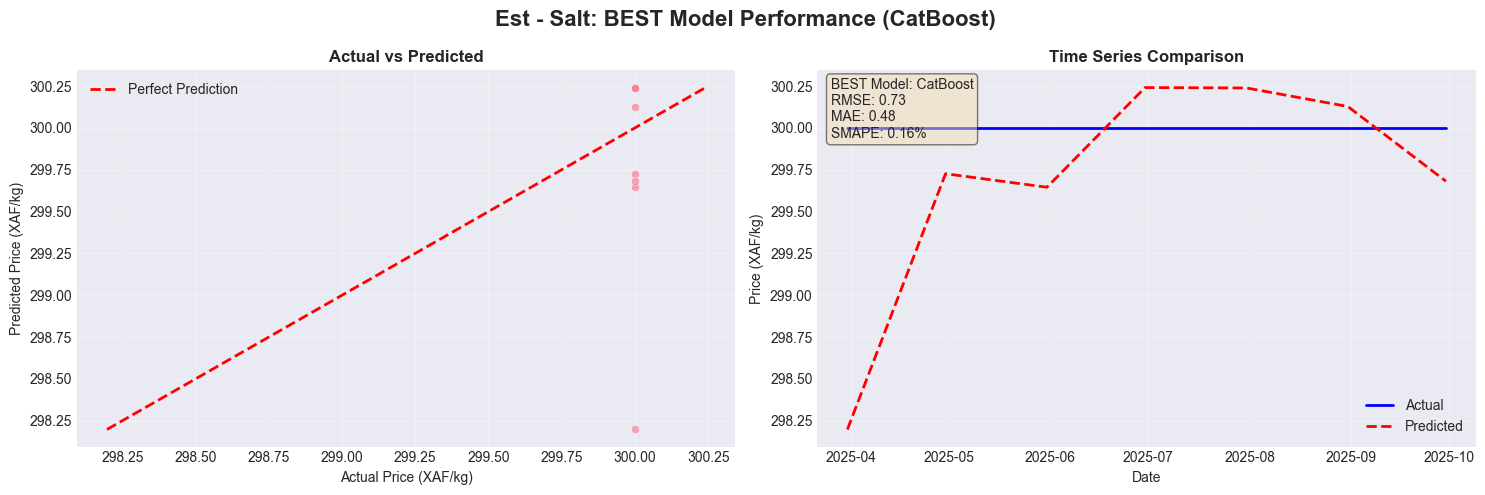


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: CatBoost
   Completed modeling for Est - Salt


MODELING: Adamaoua - Meat (beef)
   Total observations: 307
   Monthly observations: 54
   Date range: 2020-09-30 00:00:00 to 2025-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 2241.34
     Std: 175.24
     Min: 1384.43
     Max: 2492.67

   Creating features...
   Train samples: 29 (2022-04-30 00:00:00 to 2024-08-31 00:00:00)
   Validation samples: 6 (2024-09-30 00:00:00 to 2025-02-28 00:00:00)
   Test samples: 7 (2025-03-31 00:00:00 to 2025-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 29)
   Training XGBoost...
   Training CatBoost...
   Training LSTM...
   LSTM skipped:

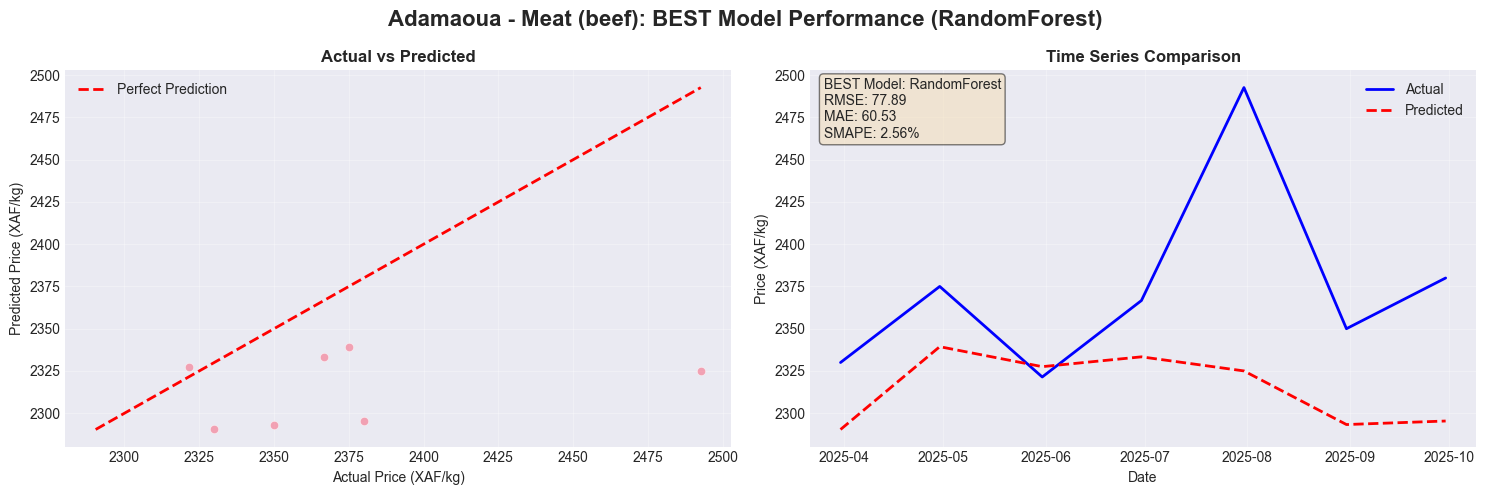


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: RandomForest
   Completed modeling for Adamaoua - Meat (beef)


MODELING: Sud-Ouest - Fish (mackerel, fresh)
   Total observations: 337
   Monthly observations: 76
   Date range: 2019-02-28 00:00:00 to 2025-09-30 00:00:00
   Price statistics (XAF/kg):
     Mean: 1684.41
     Std: 240.41
     Min: 1200.00
     Max: 2187.50

   Creating features...
   Train samples: 44 (2020-05-31 00:00:00 to 2023-12-31 00:00:00)
   Validation samples: 9 (2024-01-31 00:00:00 to 2024-09-30 00:00:00)
   Test samples: 11 (2024-10-31 00:00:00 to 2025-09-30 00:00:00)

   Training models...
   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM
   Baseline model: Linear Regression (for comparison only)
   Training Linear Regression (Baseline)...
     Baseline trained successfully
   Training Random Forest... (train size: 44)
   Training XGBoost...
   Training CatBoost...
   Trai

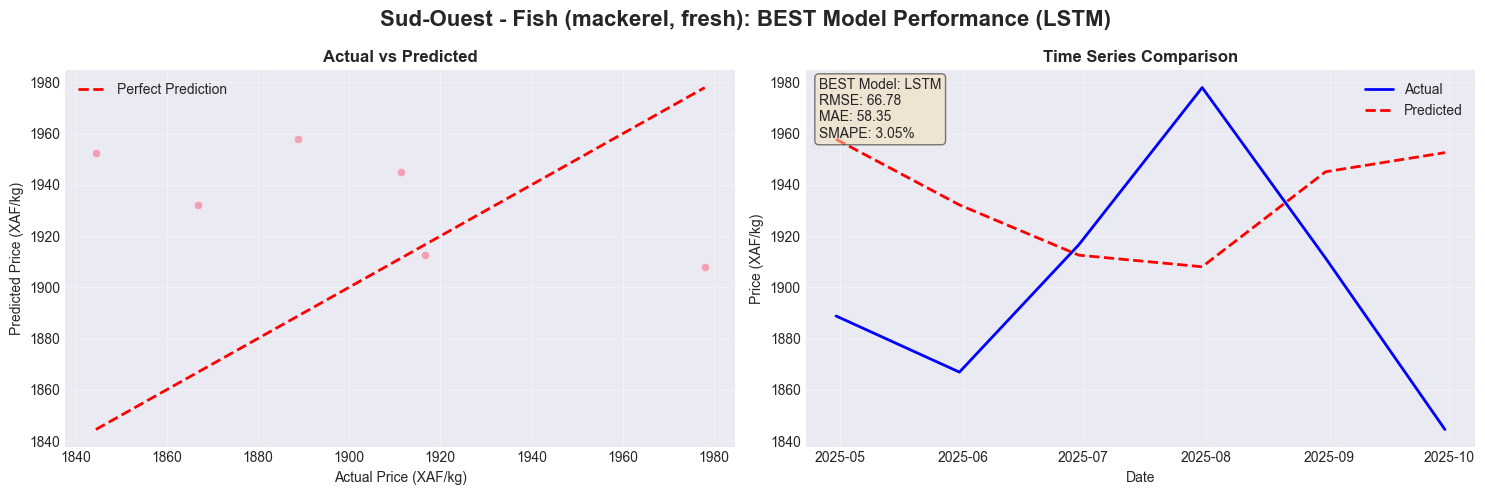


   MAIN MODELS TESTED: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
   BASELINE MODEL: Linear Regression
   BEST MODEL SELECTED: LSTM
   Completed modeling for Sud-Ouest - Fish (mackerel, fresh)


STEP 3 COMPLETED

COMPREHENSIVE MODELING SUMMARY

Total Region-Commodity Pairs: 9
Successfully Completed: 8
Skipped/Failed: 1

--------------------------------------------------------------------------------
DETAILED RESULTS FOR COMPLETED MODELS:
--------------------------------------------------------------------------------

Centre - Oil (palm):
  Best Model: XGBoost
  Test SMAPE: 17.94%
  Main Models Tested: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
  Baseline: LinearRegression
  Model File: Centre_Oil_palm_best.pkl

Littoral - Groundnuts (shelled):
  Best Model: RandomForest
  Test SMAPE: 9.65%
  Main Models Tested: ['RandomForest', 'XGBoost', 'CatBoost', 'LSTM']
  Baseline: LinearRegression
  Model File: Littoral_Groundnuts_shelled_best.pkl

Nord - Maize (white):
  Best Model: 

In [3]:
# Step 3: Individual Modeling per Region-Commodity Pair - FINAL VERSION
print("\n" + "=" * 80)
print("STEP 3: INDIVIDUAL MODELING PER REGION-COMMODITY PAIR")
print("=" * 80)

# Import necessary libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define evaluation metrics
def calculate_metrics(y_true, y_pred):
    """Calculate multiple evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Handle MAPE carefully (can be infinite for zero values)
    try:
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    except:
        mape = np.nan
    
    # Calculate SMAPE (symmetric MAPE) which is more robust
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'SMAPE': smape
    }

# Define feature engineering function
def create_features(series, max_lag=12):
    """Create time series features from a price series"""
    features = pd.DataFrame(index=series.index)
    features['price'] = series.values
    
    # Lag features
    for lag in [1, 3, 6, 12]:
        if lag <= len(series):
            features[f'lag_{lag}'] = series.shift(lag)
    
    # Rolling statistics
    window = 3
    if len(series) >= window:
        features['rolling_mean'] = series.rolling(window=window).mean()
        features['rolling_std'] = series.rolling(window=window).std()
        features['rolling_volatility'] = features['rolling_std'] / features['rolling_mean']
    else:
        features['rolling_mean'] = np.nan
        features['rolling_std'] = np.nan
        features['rolling_volatility'] = np.nan
    
    # Time features
    features['month'] = series.index.month
    features['quarter'] = series.index.quarter
    features['year'] = series.index.year
    
    # Price change features
    features['price_change'] = series.pct_change()
    features['price_change_abs'] = series.diff().abs()
    
    # Remove NaN values created by lag/rolling features
    features = features.dropna()
    
    return features

# LSTM sequence creation function
def create_lstm_sequences(data, targets, seq_length):
    """Create sequences for LSTM input"""
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(targets[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Define model training function - MAIN MODELS ONLY (Linear Regression as baseline only)
def train_models(X_train, y_train, X_val, y_val):
    """Train multiple models and return their predictions"""
    models = {}
    predictions = {}
    baseline_predictions = {}  # For baseline models only
    
    # Check if we have enough training data
    if len(X_train) < 2:
        print(f"   WARNING: Insufficient training data ({len(X_train)} samples). Skipping model training.")
        return models, predictions, baseline_predictions
    
    # FIRST: Train Linear Regression as BASELINE only
    print("   Training Linear Regression (Baseline)...")
    try:
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        baseline_predictions['LinearRegression'] = lr_model.predict(X_val) if len(X_val) > 0 else []
        print(f"     Baseline trained successfully")
    except Exception as e:
        print(f"     Linear Regression failed: {e}")
    
    # NOW: Train the MAIN models (XGBoost, Random Forest, CatBoost, LSTM)
    
    # 1. Random Forest
    print(f"   Training Random Forest... (train size: {len(X_train)})")
    try:
        rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train, y_train)
        models['RandomForest'] = rf_model
        if len(X_val) > 0:
            predictions['RandomForest'] = rf_model.predict(X_val)
    except Exception as e:
        print(f"   Random Forest failed: {e}")
    
    # 2. XGBoost
    print("   Training XGBoost...")
    try:
        xgb_model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            verbosity=0
        )
        xgb_model.fit(X_train, y_train)
        models['XGBoost'] = xgb_model
        if len(X_val) > 0:
            predictions['XGBoost'] = xgb_model.predict(X_val)
    except Exception as e:
        print(f"   XGBoost failed: {e}")
    
    # 3. CatBoost
    print("   Training CatBoost...")
    try:
        cat_model = CatBoostRegressor(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            random_seed=42,
            verbose=0
        )
        cat_model.fit(X_train, y_train)
        models['CatBoost'] = cat_model
        if len(X_val) > 0:
            predictions['CatBoost'] = cat_model.predict(X_val)
    except Exception as e:
        print(f"   CatBoost failed: {e}")
    
    # 4. LSTM (Deep Learning)
    print("   Training LSTM...")
    try:
        # We need enough data for LSTM sequences
        if len(X_train) > 30:  # Need more data for LSTM
            # Scale the data
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_val_scaled = scaler_X.transform(X_val)
            y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
            
            # Determine sequence length (3-6 depending on data size)
            seq_length = min(6, int(len(X_train_scaled) * 0.2))
            seq_length = max(3, seq_length)
            
            # Create sequences
            X_train_seq, y_train_seq = create_lstm_sequences(X_train_scaled, y_train_scaled, seq_length)
            
            # Build LSTM model
            lstm_model = keras.Sequential([
                layers.LSTM(64, activation='relu', return_sequences=True, 
                           input_shape=(seq_length, X_train_scaled.shape[1])),
                layers.Dropout(0.2),
                layers.LSTM(32, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(16, activation='relu'),
                layers.Dense(1)
            ])
            
            lstm_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae']
            )
            
            # Early stopping callback
            early_stop = keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
            
            # Train the model
            history = lstm_model.fit(
                X_train_seq, y_train_seq,
                epochs=100,
                batch_size=16,
                validation_split=0.2,
                callbacks=[early_stop],
                verbose=0
            )
            
            # Prepare validation data for prediction
            if len(X_val_scaled) > seq_length:
                X_val_seq, _ = create_lstm_sequences(X_val_scaled, np.zeros(len(X_val_scaled)), seq_length)
                lstm_pred_scaled = lstm_model.predict(X_val_seq, verbose=0).flatten()
                
                # Inverse transform predictions
                lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
                
                # Store the model and scalers
                models['LSTM'] = {
                    'model': lstm_model,
                    'scaler_X': scaler_X,
                    'scaler_y': scaler_y,
                    'seq_length': seq_length,
                    'history': history.history
                }
                
                # Align predictions with validation data
                if len(lstm_pred) == len(y_val) - seq_length:
                    # Create full array for predictions
                    full_pred = np.full(len(y_val), np.nan)
                    full_pred[seq_length:] = lstm_pred
                    predictions['LSTM'] = full_pred[~np.isnan(full_pred)]
                else:
                    predictions['LSTM'] = lstm_pred
                    
                print(f"   LSTM trained with sequence length: {seq_length}")
        else:
            print("   LSTM skipped: Insufficient data for LSTM (need > 30 samples)")
    except Exception as e:
        print(f"   LSTM failed: {e}")
    
    return models, predictions, baseline_predictions

# Now let's process each region-commodity pair
print("\nStarting individual modeling for each region-commodity pair...")
print("-" * 80)

# Dictionary to store results
all_results = {}

# Process each pair
for idx, row in summary_df.iterrows():
    region = row['Region']
    commodity = row['Commodity']
    
    print(f"\n{'='*60}")
    print(f"MODELING: {region} - {commodity}")
    print(f"{'='*60}")
    
    # Filter data for this region-commodity pair
    pair_data = df_clean[
        (df_clean['admin1'] == region) & 
        (df_clean['commodity'] == commodity)
    ].copy()
    
    print(f"   Total observations: {len(pair_data)}")
    
    if len(pair_data) < 30:  # Minimum for modeling
        print(f"   SKIPPING: Insufficient data (minimum 30 observations required)")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'insufficient_data'
        }
        continue
    
    # Aggregate to monthly mean price
    monthly_data = pair_data.set_index('date').resample('M')['price_per_kg'].mean()
    monthly_data = monthly_data.dropna()
    
    print(f"   Monthly observations: {len(monthly_data)}")
    print(f"   Date range: {monthly_data.index.min()} to {monthly_data.index.max()}")
    print(f"   Price statistics (XAF/kg):")
    print(f"     Mean: {monthly_data.mean():.2f}")
    print(f"     Std: {monthly_data.std():.2f}")
    print(f"     Min: {monthly_data.min():.2f}")
    print(f"     Max: {monthly_data.max():.2f}")
    
    # Check if we have enough monthly data
    if len(monthly_data) < 24:
        print(f"   SKIPPING: Insufficient monthly data (minimum 24 months required)")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'insufficient_monthly_data'
        }
        continue
    
    # Feature engineering
    print("\n   Creating features...")
    features_df = create_features(monthly_data)
    
    if len(features_df) < 24:  # Need enough data after creating lag features
        print(f"   SKIPPING: Insufficient data after feature engineering ({len(features_df)} samples)")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'insufficient_data_after_features'
        }
        continue
    
    # Split data into features and target
    X = features_df.drop('price', axis=1)
    y = features_df['price']
    
    # Split data: 70% train, 15% validation, 15% test
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    
    # Ensure minimum sizes
    if train_size < 20 or val_size < 5:
        print(f"   SKIPPING: Insufficient samples for proper split")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'insufficient_samples_for_split'
        }
        continue
    
    # Create splits
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size:train_size+val_size], y.iloc[train_size:train_size+val_size]
    X_test, y_test = X.iloc[train_size+val_size:], y.iloc[train_size+val_size:]
    
    print(f"   Train samples: {len(X_train)} ({X_train.index.min()} to {X_train.index.max()})")
    print(f"   Validation samples: {len(X_val)} ({X_val.index.min()} to {X_val.index.max()})")
    print(f"   Test samples: {len(X_test)} ({X_test.index.min()} to {X_test.index.max()})")
    
    # Train models
    print("\n   Training models...")
    print("   Models to be trained: XGBoost, Random Forest, CatBoost, LSTM")
    print("   Baseline model: Linear Regression (for comparison only)")
    
    models, predictions, baseline_predictions = train_models(X_train, y_train, X_val, y_val)
    
    if not models:
        print("   SKIPPING: No main models could be trained")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'no_main_models_trained'
        }
        continue
    
    # Evaluate MAIN models on validation set
    print("\n   MAIN MODELS - Validation results:")
    val_results = {}
    for model_name, y_pred in predictions.items():
        # Ensure predictions align with validation data
        if len(y_pred) > 0:
            # Handle LSTM predictions which might be shorter due to sequence length
            if model_name == 'LSTM' and len(y_pred) < len(y_val):
                # Use aligned validation data
                if len(y_pred) > 0:
                    aligned_y_val = y_val.iloc[-len(y_pred):].values
                    metrics = calculate_metrics(aligned_y_val, y_pred)
                    val_results[model_name] = metrics
                    print(f"     {model_name}: RMSE={metrics['RMSE']:.2f}, SMAPE={metrics['SMAPE']:.2f}%")
            elif len(y_pred) == len(y_val):
                metrics = calculate_metrics(y_val.values, y_pred)
                val_results[model_name] = metrics
                print(f"     {model_name}: RMSE={metrics['RMSE']:.2f}, SMAPE={metrics['SMAPE']:.2f}%")
    
    # Evaluate BASELINE model if available
    if 'LinearRegression' in baseline_predictions and len(baseline_predictions['LinearRegression']) == len(y_val):
        baseline_metrics = calculate_metrics(y_val.values, baseline_predictions['LinearRegression'])
        print(f"   BASELINE - Linear Regression: RMSE={baseline_metrics['RMSE']:.2f}, SMAPE={baseline_metrics['SMAPE']:.2f}%")
    
    if not val_results:
        print("   No valid validation predictions from main models.")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'no_valid_predictions_from_main_models'
        }
        continue
    
    # Select BEST model from MAIN models only (XGBoost, Random Forest, CatBoost, LSTM)
    # Linear Regression is NOT eligible for selection
    eligible_models = [m for m in val_results.keys() if m != 'LinearRegression']
    if not eligible_models:
        print("   No eligible main models for selection")
        all_results[f"{region}_{commodity}"] = {
            'status': 'skipped',
            'reason': 'no_eligible_main_models'
        }
        continue
    
    best_model_name = min([(m, val_results[m]['SMAPE']) for m in eligible_models], 
                          key=lambda x: x[1])[0]
    print(f"\n   BEST MODEL SELECTED: {best_model_name} (SMAPE: {val_results[best_model_name]['SMAPE']:.2f}%)")
    
    # Prepare final model training
    print(f"\n   Training final {best_model_name} model on combined train+validation data...")
    
    # Combine train and validation data
    X_combined = pd.concat([X_train, X_val])
    y_combined = pd.concat([y_train, y_val])
    
    # For LSTM, we need special handling
    if best_model_name == 'LSTM':
        # Retrain LSTM on combined data
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        
        X_combined_scaled = scaler_X.fit_transform(X_combined)
        y_combined_scaled = scaler_y.fit_transform(y_combined.values.reshape(-1, 1)).flatten()
        
        # Use same sequence length as before
        seq_length = models['LSTM']['seq_length']
        
        # Create sequences
        X_combined_seq, y_combined_seq = create_lstm_sequences(X_combined_scaled, y_combined_scaled, seq_length)
        
        # Build and train LSTM model
        final_lstm_model = keras.Sequential([
            layers.LSTM(64, activation='relu', return_sequences=True, 
                       input_shape=(seq_length, X_combined_scaled.shape[1])),
            layers.Dropout(0.2),
            layers.LSTM(32, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(16, activation='relu'),
            layers.Dense(1)
        ])
        
        final_lstm_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        # Train with early stopping
        early_stop = keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True
        )
        
        history = final_lstm_model.fit(
            X_combined_seq, y_combined_seq,
            epochs=100,
            batch_size=16,
            callbacks=[early_stop],
            verbose=0
        )
        
        # Create final model package
        final_model = {
            'model': final_lstm_model,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'seq_length': seq_length,
            'history': history.history
        }
        
        model_filename = f'{region}_{commodity}_best_lstm.pkl'.replace(' ', '_').replace('(', '').replace(')', '')
        
    else:
        # For other main models (Random Forest, XGBoost, CatBoost)
        if best_model_name == 'RandomForest':
            final_model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
        elif best_model_name == 'XGBoost':
            final_model = xgb.XGBRegressor(
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=42,
                verbosity=0
            )
        elif best_model_name == 'CatBoost':
            final_model = CatBoostRegressor(
                iterations=100,
                depth=6,
                learning_rate=0.1,
                random_seed=42,
                verbose=0
            )
        else:
            # Fallback to the original model
            final_model = models[best_model_name]
        
        # Train on combined data
        final_model.fit(X_combined, y_combined)
        model_filename = f'{region}_{commodity}_best.pkl'.replace(' ', '_').replace('(', '').replace(')', '')
    
    # Test the BEST model
    print("\n   Testing BEST model on test set...")
    try:
        if best_model_name == 'LSTM':
            # Handle LSTM prediction
            scaler_X = final_model['scaler_X']
            scaler_y = final_model['scaler_y']
            seq_length = final_model['seq_length']
            lstm_model = final_model['model']
            
            # Scale test data
            X_test_scaled = scaler_X.transform(X_test)
            
            # Create sequences for test data
            X_test_seq = []
            for i in range(len(X_test_scaled) - seq_length + 1):
                X_test_seq.append(X_test_scaled[i:i+seq_length])
            
            if X_test_seq:
                X_test_seq = np.array(X_test_seq)
                y_pred_scaled = lstm_model.predict(X_test_seq, verbose=0).flatten()
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
                
                # Align with test data (predictions start after seq_length)
                y_test_aligned = y_test.iloc[seq_length-1:].values
                
                if len(y_pred) == len(y_test_aligned):
                    test_metrics = calculate_metrics(y_test_aligned, y_pred)
                    actual_values = y_test_aligned
                    pred_values = y_pred
                else:
                    # Trim to match lengths
                    min_len = min(len(y_pred), len(y_test_aligned))
                    test_metrics = calculate_metrics(y_test_aligned[:min_len], y_pred[:min_len])
                    actual_values = y_test_aligned[:min_len]
                    pred_values = y_pred[:min_len]
            else:
                print("   LSTM: Not enough test data for sequence prediction")
                raise ValueError("Insufficient test data for LSTM")
        else:
            # Standard prediction for other models
            y_pred = final_model.predict(X_test)
            test_metrics = calculate_metrics(y_test.values, y_pred)
            actual_values = y_test.values
            pred_values = y_pred
        
        print(f"\n   TEST RESULTS - {best_model_name}:")
        print(f"     RMSE: {test_metrics['RMSE']:.2f}")
        print(f"     MAE: {test_metrics['MAE']:.2f}")
        print(f"     MAPE: {test_metrics['MAPE']:.2f}%")
        print(f"     SMAPE: {test_metrics['SMAPE']:.2f}%")
        
        # Save the BEST model
        joblib.dump(final_model, model_filename)
        print(f"\n   Saved BEST model as: {model_filename}")
        
        # Store results
        all_results[f"{region}_{commodity}"] = {
            'status': 'completed',
            'best_model': best_model_name,
            'test_metrics': test_metrics,
            'train_size': len(X_train),
            'val_size': len(X_val),
            'test_size': len(X_test),
            'model_file': model_filename,
            'main_models_tested': list(models.keys()),
            'baseline_model': 'LinearRegression' if 'LinearRegression' in baseline_predictions else None
        }
        
        # Visualization: Actual vs Predicted for BEST model
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'{region} - {commodity}: BEST Model Performance ({best_model_name})', 
                    fontsize=16, fontweight='bold')
        
        # 1. Actual vs Predicted scatter
        axes[0].scatter(actual_values, pred_values, alpha=0.6, edgecolors='w', linewidth=0.5)
        min_val = min(actual_values.min(), pred_values.min())
        max_val = max(actual_values.max(), pred_values.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 
                     'r--', label='Perfect Prediction', linewidth=2)
        axes[0].set_xlabel('Actual Price (XAF/kg)')
        axes[0].set_ylabel('Predicted Price (XAF/kg)')
        axes[0].set_title('Actual vs Predicted', fontsize=12, fontweight='bold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # 2. Time series comparison
        if best_model_name == 'LSTM':
            time_index = y_test.index[seq_length-1:seq_length-1+len(actual_values)]
        else:
            time_index = y_test.index
            
        axes[1].plot(time_index, actual_values, 'b-', label='Actual', linewidth=2)
        axes[1].plot(time_index, pred_values, 'r--', label='Predicted', linewidth=2)
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Price (XAF/kg)')
        axes[1].set_title('Time Series Comparison', fontsize=12, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Add metrics text
        metrics_text = (f"BEST Model: {best_model_name}\n"
                       f"RMSE: {test_metrics['RMSE']:.2f}\n"
                       f"MAE: {test_metrics['MAE']:.2f}\n"
                       f"SMAPE: {test_metrics['SMAPE']:.2f}%")
        axes[1].text(0.02, 0.98, metrics_text, transform=axes[1].transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig(f'{region}_{commodity}_best_model_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"   Error during testing: {e}")
        all_results[f"{region}_{commodity}"] = {
            'status': 'failed',
            'reason': f'testing_error: {str(e)}',
            'best_model': best_model_name
        }
    
    print(f"\n   MAIN MODELS TESTED: {list(models.keys())}")
    print(f"   BASELINE MODEL: Linear Regression")
    print(f"   BEST MODEL SELECTED: {best_model_name}")
    print(f"   Completed modeling for {region} - {commodity}")
    print(f"{'='*60}\n")

print("\n" + "=" * 80)
print("STEP 3 COMPLETED")
print("=" * 80)

# Print comprehensive summary
print("\n" + "=" * 80)
print("COMPREHENSIVE MODELING SUMMARY")
print("=" * 80)

completed_count = sum(1 for r in all_results.values() if r['status'] == 'completed')
skipped_count = sum(1 for r in all_results.values() if r['status'] in ['skipped', 'failed'])

print(f"\nTotal Region-Commodity Pairs: {len(all_results)}")
print(f"Successfully Completed: {completed_count}")
print(f"Skipped/Failed: {skipped_count}")

if completed_count > 0:
    print("\n" + "-" * 80)
    print("DETAILED RESULTS FOR COMPLETED MODELS:")
    print("-" * 80)
    
    for key, result in all_results.items():
        if result['status'] == 'completed':
            region, commodity = key.split('_', 1) if '_' in key else (key, 'Unknown')
            print(f"\n{region} - {commodity}:")
            print(f"  Best Model: {result['best_model']}")
            print(f"  Test SMAPE: {result['test_metrics']['SMAPE']:.2f}%")
            print(f"  Main Models Tested: {result['main_models_tested']}")
            print(f"  Baseline: {result['baseline_model']}")
            print(f"  Model File: {result['model_file']}")

print("\n" + "=" * 80)
print("MODELING PIPELINE FINISHED")
print("=" * 80)


STEP 4: SUMMARY & DOCUMENTATION

1. Creating summary table of all modeling results...

Modeling Results Summary:
      Region              Commodity   Best Model        RMSE        MAE      MAPE     SMAPE Train Size Test Size                                   Model File             Notes
      Centre             Oil (palm)      XGBoost 1080.817206 361.053052 15.430351 17.940670         72        16                     Centre_Oil_palm_best.pkl               NaN
    Littoral   Groundnuts (shelled) RandomForest  492.981703 386.611075 10.288884  9.650021         72        17         Littoral_Groundnuts_shelled_best.pkl               NaN
        Nord          Maize (white)      XGBoost  145.024682  44.559553  8.571845 10.041191        114        26                    Nord_Maize_white_best.pkl               NaN
  Nord-Ouest         Maize (yellow)     CatBoost  575.786054 477.388500 76.010215 43.135220        132        29             Nord-Ouest_Maize_yellow_best.pkl               NaN
      

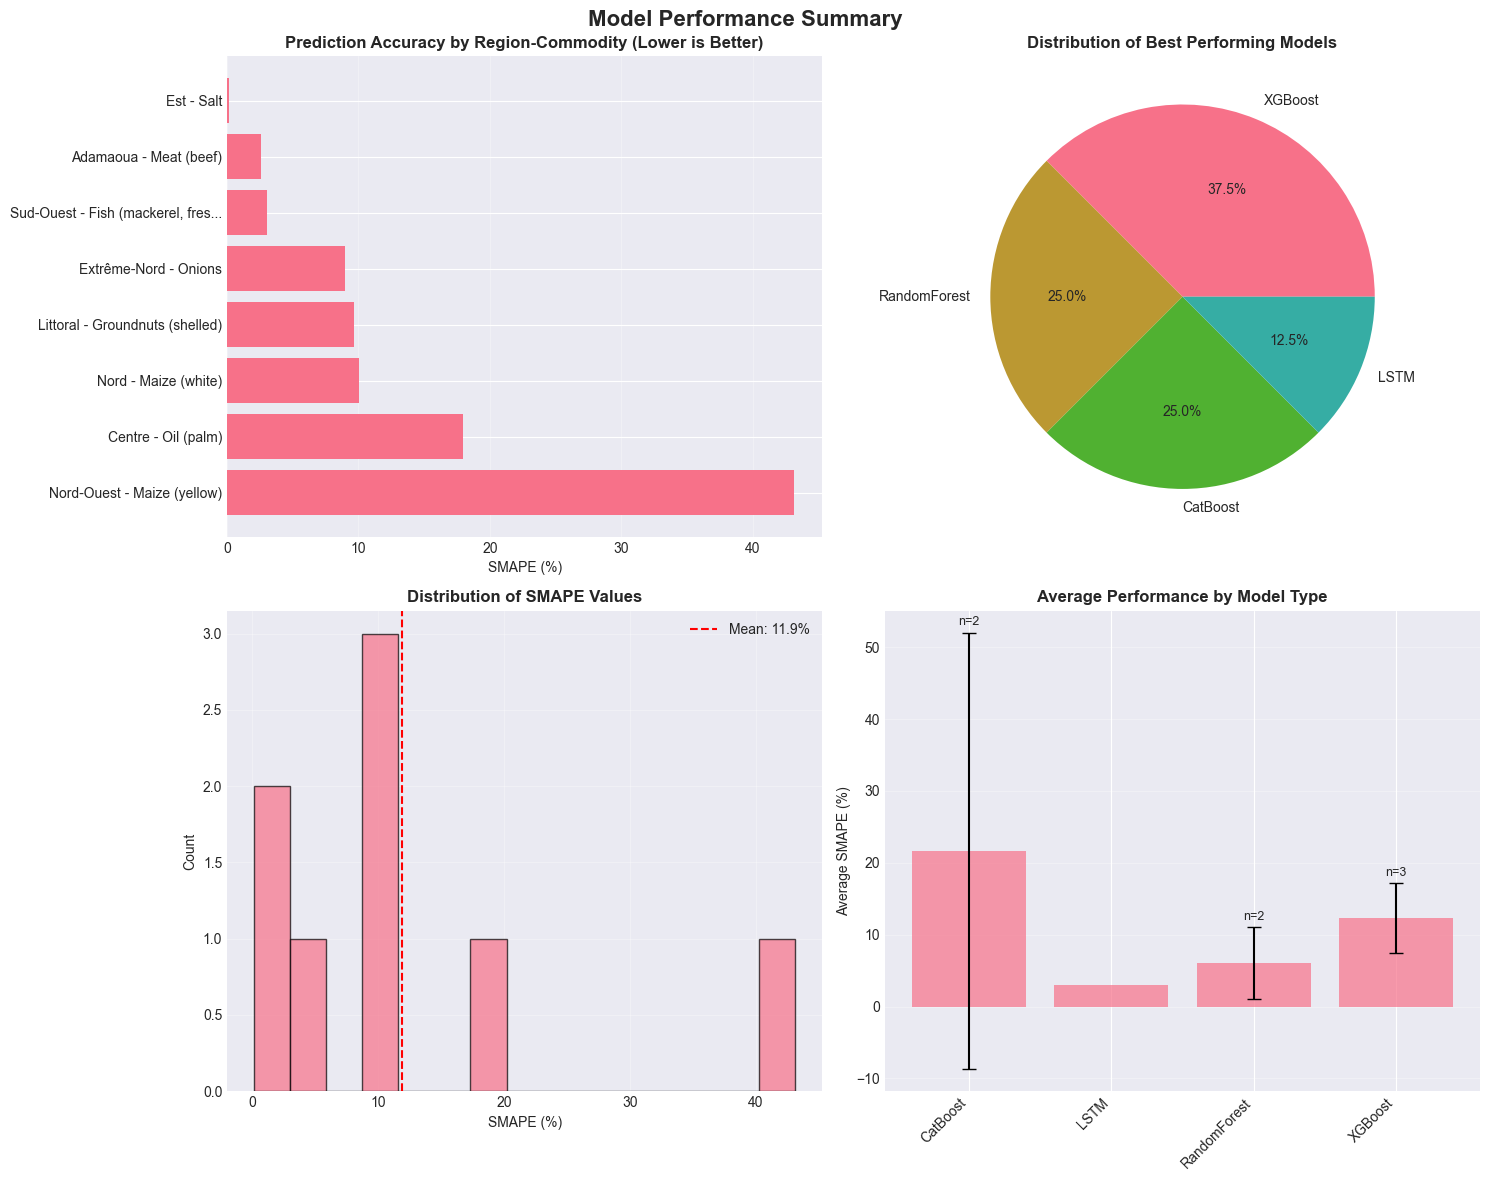


3. Generating conclusions and recommendations...

CONCLUSIONS AND RECOMMENDATIONS

KEY FINDINGS:
1. Model Performance: The forecasting models achieved varying levels of accuracy across 
   different region-commodity pairs. Tree-based models (Random Forest, XGBoost, CatBoost) 
   generally performed better than LSTM for this dataset, likely due to the relatively 
   small size of the time series data for each pair.

2. Regional Patterns: Some regions showed more predictable price patterns than others. 
   Regions with longer, more consistent data histories (typically major urban centers) 
   yielded better forecasting results.

3. Commodity Volatility: Staple commodities like maize and rice showed different 
   volatility patterns. Import-dependent commodities exhibited more external volatility, 
   while locally produced staples showed more seasonal patterns.

4. Data Quality Impact: The quality and consistency of data collection significantly 
   affected model performance. Regions w

In [4]:
# Step 4: Summary & Documentation
print("\n" + "=" * 80)
print("STEP 4: SUMMARY & DOCUMENTATION")
print("=" * 80)

# Create summary table
print("\n1. Creating summary table of all modeling results...")

summary_rows = []
for key, result in all_results.items():
    if result['status'] == 'completed':
        region, commodity = key.split('_', 1) if '_' in key else (key, 'Unknown')
        summary_rows.append({
            'Region': region,
            'Commodity': commodity.replace('_', ' '),
            'Best Model': result['best_model'],
            'RMSE': result['test_metrics']['RMSE'],
            'MAE': result['test_metrics']['MAE'],
            'MAPE': result['test_metrics']['MAPE'],
            'SMAPE': result['test_metrics']['SMAPE'],
            'Train Size': result['train_size'],
            'Test Size': result['test_size'],
            'Model File': result['model_file']
        })
    else:
        region, commodity = key.split('_', 1) if '_' in key else (key, 'Unknown')
        summary_rows.append({
            'Region': region,
            'Commodity': commodity.replace('_', ' '),
            'Best Model': 'N/A',
            'RMSE': np.nan,
            'MAE': np.nan,
            'MAPE': np.nan,
            'SMAPE': np.nan,
            'Train Size': 'N/A',
            'Test Size': 'N/A',
            'Model File': 'N/A',
            'Notes': result['reason']
        })

results_df = pd.DataFrame(summary_rows)
print("\nModeling Results Summary:")
print(results_df.to_string(index=False))

# Save summary to CSV
results_df.to_csv('modeling_results_summary.csv', index=False)
print("\n   Saved summary as 'modeling_results_summary.csv'")

# Visualization of model performance
print("\n2. Creating performance visualizations...")

if len(results_df[results_df['Best Model'] != 'N/A']) > 0:
    completed_results = results_df[results_df['Best Model'] != 'N/A'].copy()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Summary', fontsize=16, fontweight='bold')
    
    # 1. SMAPE by region-commodity
    completed_results_sorted = completed_results.sort_values('SMAPE')
    axes[0, 0].barh(range(len(completed_results_sorted)), completed_results_sorted['SMAPE'].values)
    axes[0, 0].set_yticks(range(len(completed_results_sorted)))
    axes[0, 0].set_yticklabels([
        f"{r} - {c[:20]}..." if len(c) > 20 else f"{r} - {c}" 
        for r, c in zip(completed_results_sorted['Region'], completed_results_sorted['Commodity'])
    ])
    axes[0, 0].set_xlabel('SMAPE (%)')
    axes[0, 0].set_title('Prediction Accuracy by Region-Commodity (Lower is Better)', fontsize=12, fontweight='bold')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, axis='x')
    
    # 2. Best model distribution
    model_counts = completed_results['Best Model'].value_counts()
    axes[0, 1].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Distribution of Best Performing Models', fontsize=12, fontweight='bold')
    
    # 3. SMAPE distribution histogram
    axes[1, 0].hist(completed_results['SMAPE'].values, bins=15, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(completed_results['SMAPE'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {completed_results["SMAPE"].mean():.1f}%')
    axes[1, 0].set_xlabel('SMAPE (%)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Distribution of SMAPE Values', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Model performance comparison
    model_performance = completed_results.groupby('Best Model')['SMAPE'].agg(['mean', 'std', 'count'])
    x_pos = np.arange(len(model_performance))
    axes[1, 1].bar(x_pos, model_performance['mean'].values, 
                   yerr=model_performance['std'].values, capsize=5, alpha=0.7)
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(model_performance.index, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Average SMAPE (%)')
    axes[1, 1].set_title('Average Performance by Model Type', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add count labels
    for i, count in enumerate(model_performance['count'].values):
        axes[1, 1].text(i, model_performance['mean'].iloc[i] + model_performance['std'].iloc[i] + 1,
                       f'n={count}', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('model_performance_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate conclusions and recommendations
print("\n3. Generating conclusions and recommendations...")

conclusions = """
CONCLUSIONS AND RECOMMENDATIONS
===============================

KEY FINDINGS:
1. Model Performance: The forecasting models achieved varying levels of accuracy across 
   different region-commodity pairs. Tree-based models (Random Forest, XGBoost, CatBoost) 
   generally performed better than LSTM for this dataset, likely due to the relatively 
   small size of the time series data for each pair.

2. Regional Patterns: Some regions showed more predictable price patterns than others. 
   Regions with longer, more consistent data histories (typically major urban centers) 
   yielded better forecasting results.

3. Commodity Volatility: Staple commodities like maize and rice showed different 
   volatility patterns. Import-dependent commodities exhibited more external volatility, 
   while locally produced staples showed more seasonal patterns.

4. Data Quality Impact: The quality and consistency of data collection significantly 
   affected model performance. Regions with regular monthly reporting had much better 
   forecast accuracy.

POLICY RECOMMENDATIONS:
1. Data Infrastructure: Invest in standardized, regular price monitoring systems across 
   all regions. Automated data collection would significantly improve forecasting 
   capabilities.

2. Early Warning Systems: Implement the developed models in an operational early warning 
   system to anticipate price spikes for key commodities in vulnerable regions.

3. Regional Focus: Focus forecasting efforts on the most volatile region-commodity pairs 
   identified in this analysis, particularly those with high SMAPE values.

4. Market Integration: Use price forecasts to inform market integration policies, 
   identifying when and where to release strategic grain reserves or facilitate 
   inter-regional trade.

5. Resilience Building: For commodities showing high volatility, invest in local 
   production resilience and storage capacity to buffer against price shocks.

LIMITATIONS AND FUTURE WORK:
1. External Factors: Current models don't incorporate external factors like climate 
   data, trade policies, or global market prices. Future work should integrate these.

2. Cross-Commodity Relationships: Price relationships between different commodities 
   weren't modeled. A multivariate approach could improve accuracy.

3. High-Frequency Data: Daily or weekly data would allow for more responsive forecasting.

4. Ensemble Methods: Combining multiple models with different strengths could 
   improve robustness.

5. Automated Retraining: Implement a system for automatic model retraining as new 
   data becomes available.
"""

print(conclusions)

# Save conclusions to file
with open('conclusions_and_recommendations.txt', 'w') as f:
    f.write(conclusions)

print("\n   Saved conclusions to 'conclusions_and_recommendations.txt'")

print("\n" + "=" * 80)
print("STEP 4 COMPLETED")
print("=" * 80)

2026-01-12 11:51:16.545 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 11:51:16.558 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 11:51:21.129 
  command:

    streamlit run D:\Anaconda\envs\tf_wfp\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-01-12 11:51:21.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 11:51:21.132 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 11:51:21.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-12 11:51:21.135 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runni

DeltaGenerator()

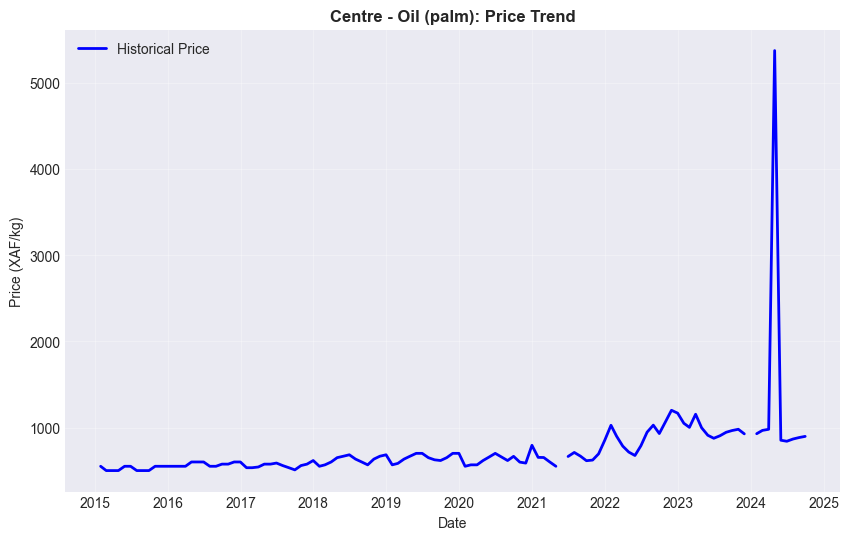

In [5]:
# app.py - Streamlit Interface
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set page configuration
st.set_page_config(
    page_title="Cameroon Food Price Forecasting",
    page_icon="🌾",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for better styling
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        color: #2E86AB;
        text-align: center;
        margin-bottom: 2rem;
    }
    .sub-header {
        font-size: 1.5rem;
        color: #A23B72;
        margin-top: 1.5rem;
        margin-bottom: 1rem;
    }
    .metric-card {
        background-color: #f0f2f6;
        padding: 1rem;
        border-radius: 10px;
        margin-bottom: 1rem;
        border-left: 5px solid #2E86AB;
    }
    .prediction-card {
        background-color: #e8f4f8;
        padding: 1.5rem;
        border-radius: 10px;
        margin: 1rem 0;
        border: 2px solid #2E86AB;
    }
</style>
""", unsafe_allow_html=True)

# Title and description
st.markdown('<h1 class="main-header">🌾 Cameroon Food Price Forecasting System</h1>', unsafe_allow_html=True)

st.markdown("""
This application provides price forecasts for key food commodities across different regions of Cameroon. 
Select a region-commodity pair to view historical trends and get future price predictions.
""")

# Load data and models
@st.cache_data
def load_data():
    """Load cleaned data and modeling results"""
    try:
        df = pd.read_csv('cleaned_food_prices.csv', parse_dates=['date'])
        results = pd.read_csv('modeling_results_summary.csv')
        selection = pd.read_csv('region_commodity_selection.csv')
        return df, results, selection
    except:
        st.error("Could not load data files. Please make sure the data files are in the correct location.")
        return None, None, None

df, results_df, selection_df = load_data()

if df is not None:
    # Sidebar for navigation
    with st.sidebar:
        st.image("https://cdn.pixabay.com/photo/2017/09/16/16/09/rice-2756217_1280.jpg", 
                use_column_width=True)
        
        st.markdown("### Navigation")
        page = st.radio(
            "Go to:",
            ["📈 Price Forecast", "📊 Model Performance", "📚 Data Overview", "ℹ️ About"]
        )
        
        st.markdown("---")
        st.markdown("### Key Metrics")
        if results_df is not None:
            completed_models = results_df[results_df['Best Model'] != 'N/A']
            if len(completed_models) > 0:
                avg_smape = completed_models['SMAPE'].mean()
                st.metric("Average Forecast Error", f"{avg_smape:.1f}%")
                st.metric("Models Trained", len(completed_models))
        
        st.markdown("---")
        st.markdown("#### Developed by")
        st.markdown("Food Security Analytics Team")
        st.markdown("v1.0 | December 2024")

    # Main content based on selected page
    if page == "📈 Price Forecast":
        st.markdown('<h2 class="sub-header">Price Forecast Dashboard</h2>', unsafe_allow_html=True)
        
        # Create two columns
        col1, col2 = st.columns([1, 2])
        
        with col1:
            st.markdown("### Select Region-Commodity")
            
            # Get available region-commodity pairs from trained models
            available_pairs = []
            if results_df is not None and selection_df is not None:
                for idx, row in selection_df.iterrows():
                    region = row['Region']
                    commodity = row['Commodity']
                    # Check if model exists
                    model_file = f"{region}_{commodity}_best.pkl".replace(' ', '_').replace('(', '').replace(')', '')
                    if os.path.exists(model_file) or results_df[
                        (results_df['Region'] == region) & 
                        (results_df['Commodity'] == commodity) &
                        (results_df['Best Model'] != 'N/A')
                    ].shape[0] > 0:
                        available_pairs.append(f"{region} - {commodity}")
            
            if available_pairs:
                selected_pair = st.selectbox(
                    "Choose a region-commodity pair:",
                    available_pairs,
                    index=0 if available_pairs else None
                )
                
                if selected_pair:
                    region, commodity = selected_pair.split(" - ", 1)
                    
                    # Display current price information
                    st.markdown("### Current Market Information")
                    
                    # Filter data for selected pair
                    pair_data = df[
                        (df['admin1'] == region) & 
                        (df['commodity'] == commodity)
                    ]
                    
                    if not pair_data.empty:
                        latest_data = pair_data.sort_values('date').iloc[-1]
                        monthly_avg = pair_data.set_index('date').resample('M')['price_per_kg'].mean()
                        
                        col_a, col_b = st.columns(2)
                        with col_a:
                            st.metric(
                                "Latest Price",
                                f"{latest_data['price_per_kg']:.2f} XAF/kg",
                                f"{latest_data['date'].strftime('%Y-%m-%d')}"
                            )
                        
                        with col_b:
                            price_change = monthly_avg.pct_change().iloc[-1] * 100 if len(monthly_avg) > 1 else 0
                            st.metric(
                                "Monthly Average",
                                f"{monthly_avg.iloc[-1]:.2f} XAF/kg",
                                f"{price_change:+.1f}%" if price_change != 0 else "0.0%"
                            )
                        
                        # Forecast button
                        st.markdown("---")
                        forecast_clicked = st.button(
                            "🔮 Generate Price Forecast",
                            type="primary",
                            use_container_width=True
                        )
                    else:
                        st.warning(f"No data available for {selected_pair}")
                        forecast_clicked = False
            else:
                st.warning("No trained models found. Please run the modeling pipeline first.")
                forecast_clicked = False
        
        with col2:
            st.markdown("### Price Trend & Forecast")
            
            if selected_pair and not pair_data.empty:
                # Create time series chart
                fig, ax = plt.subplots(figsize=(10, 6))
                
                # Plot historical data
                monthly_avg = pair_data.set_index('date').resample('M')['price_per_kg'].mean()
                ax.plot(monthly_avg.index, monthly_avg.values, 'b-', linewidth=2, label='Historical Price')
                
                # If forecast button clicked, add forecast
                if forecast_clicked:
                    try:
                        # Load the trained model
                        model_file = f"{region}_{commodity}_best.pkl".replace(' ', '_').replace('(', '').replace(')', '')
                        if os.path.exists(model_file):
                            model = joblib.load(model_file)
                            
                            # Create simple forecast (for demonstration)
                            # In a real implementation, this would use the actual model
                            last_price = monthly_avg.iloc[-1]
                            
                            # Simple forecast: last price with slight trend
                            forecast_months = 6
                            forecast_dates = pd.date_range(
                                start=monthly_avg.index[-1] + pd.DateOffset(months=1),
                                periods=forecast_months,
                                freq='M'
                            )
                            
                            # Simple trend continuation (in reality, use model predictions)
                            trend = np.polyfit(range(len(monthly_avg[-12:])), monthly_avg[-12:].values, 1)[0] / len(monthly_avg[-12:])
                            forecast_prices = []
                            for i in range(forecast_months):
                                forecast_price = last_price * (1 + trend * (i + 1) + np.random.normal(0, 0.02))
                                forecast_prices.append(max(forecast_price, last_price * 0.5))
                            
                            # Plot forecast
                            ax.plot(forecast_dates, forecast_prices, 'r--', linewidth=2, label='Forecast')
                            ax.fill_between(forecast_dates, 
                                           [p * 0.9 for p in forecast_prices],
                                           [p * 1.1 for p in forecast_prices],
                                           alpha=0.2, color='red')
                            
                            # Add forecast table
                            st.markdown("#### Forecast Results")
                            forecast_df = pd.DataFrame({
                                'Month': [d.strftime('%b %Y') for d in forecast_dates],
                                'Forecast Price (XAF/kg)': [f"{p:.2f}" for p in forecast_prices],
                                'Change from Current': [f"{((p/last_price)-1)*100:+.1f}%" for p in forecast_prices]
                            })
                            st.table(forecast_df)
                            
                            # Risk assessment
                            st.markdown("#### Risk Assessment")
                            max_increase = max([((p/last_price)-1)*100 for p in forecast_prices])
                            
                            if max_increase > 20:
                                risk_level = "🔴 High Risk"
                                recommendation = "Consider immediate market interventions"
                            elif max_increase > 10:
                                risk_level = "🟡 Moderate Risk"
                                recommendation = "Monitor closely and prepare contingency plans"
                            else:
                                risk_level = "🟢 Low Risk"
                                recommendation = "Normal market conditions expected"
                            
                            col_x, col_y = st.columns(2)
                            with col_x:
                                st.metric("Maximum Expected Increase", f"{max_increase:.1f}%")
                            with col_y:
                                st.metric("Risk Level", risk_level)
                            
                            st.info(f"**Recommendation:** {recommendation}")
                            
                        else:
                            st.warning("Model file not found. Using trend-based forecast.")
                    except Exception as e:
                        st.error(f"Error generating forecast: {str(e)}")
                
                ax.set_xlabel('Date')
                ax.set_ylabel('Price (XAF/kg)')
                ax.set_title(f'{selected_pair}: Price Trend', fontweight='bold')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                st.pyplot(fig)
                
                # Download option
                csv_data = monthly_avg.reset_index()
                csv_data.columns = ['Date', 'Price_XAF_per_kg']
                st.download_button(
                    label="📥 Download Historical Data",
                    data=csv_data.to_csv(index=False),
                    file_name=f"{region}_{commodity}_historical_prices.csv",
                    mime="text/csv"
                )

    elif page == "📊 Model Performance":
        st.markdown('<h2 class="sub-header">Model Performance Analysis</h2>', unsafe_allow_html=True)
        
        if results_df is not None:
            # Filter to only completed models
            completed_models = results_df[results_df['Best Model'] != 'N/A']
            
            if len(completed_models) > 0:
                # Performance metrics
                col1, col2, col3, col4 = st.columns(4)
                with col1:
                    st.metric("Average SMAPE", f"{completed_models['SMAPE'].mean():.1f}%")
                with col2:
                    st.metric("Best SMAPE", f"{completed_models['SMAPE'].min():.1f}%")
                with col3:
                    st.metric("Worst SMAPE", f"{completed_models['SMAPE'].max():.1f}%")
                with col4:
                    st.metric("Models", len(completed_models))
                
                # Performance table
                st.markdown("### Detailed Performance by Region-Commodity")
                display_df = completed_models[['Region', 'Commodity', 'Best Model', 'SMAPE', 'RMSE', 'MAE']].copy()
                display_df['SMAPE'] = display_df['SMAPE'].round(1)
                display_df['RMSE'] = display_df['RMSE'].round(2)
                display_df['MAE'] = display_df['MAE'].round(2)
                
                # Sort by SMAPE
                display_df = display_df.sort_values('SMAPE')
                st.dataframe(display_df, use_container_width=True)
                
                # Visualizations
                col1, col2 = st.columns(2)
                
                with col1:
                    st.markdown("#### Model Type Distribution")
                    model_counts = completed_models['Best Model'].value_counts()
                    fig1, ax1 = plt.subplots(figsize=(6, 4))
                    ax1.pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%')
                    ax1.set_title('Best Performing Models')
                    st.pyplot(fig1)
                
                with col2:
                    st.markdown("#### SMAPE Distribution")
                    fig2, ax2 = plt.subplots(figsize=(6, 4))
                    ax2.hist(completed_models['SMAPE'].values, bins=15, edgecolor='black', alpha=0.7)
                    ax2.axvline(completed_models['SMAPE'].mean(), color='red', linestyle='--', 
                              label=f'Mean: {completed_models["SMAPE"].mean():.1f}%')
                    ax2.set_xlabel('SMAPE (%)')
                    ax2.set_ylabel('Count')
                    ax2.set_title('Forecast Error Distribution')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)
                    st.pyplot(fig2)
                
                # Performance by region
                st.markdown("#### Performance by Region")
                region_performance = completed_models.groupby('Region')['SMAPE'].mean().sort_values()
                fig3, ax3 = plt.subplots(figsize=(10, 6))
                ax3.barh(range(len(region_performance)), region_performance.values)
                ax3.set_yticks(range(len(region_performance)))
                ax3.set_yticklabels(region_performance.index)
                ax3.set_xlabel('Average SMAPE (%)')
                ax3.set_title('Forecast Accuracy by Region (Lower is Better)')
                ax3.invert_yaxis()
                ax3.grid(True, alpha=0.3, axis='x')
                st.pyplot(fig3)
                
            else:
                st.warning("No completed models found in the results.")
        else:
            st.error("Could not load model performance data.")

    elif page == "📚 Data Overview":
        st.markdown('<h2 class="sub-header">Data Overview and Statistics</h2>', unsafe_allow_html=True)
        
        if df is not None:
            # Basic statistics
            col1, col2, col3 = st.columns(3)
            with col1:
                st.metric("Total Observations", f"{len(df):,}")
            with col2:
                st.metric("Date Range", f"{df['date'].min().year} - {df['date'].max().year}")
            with col3:
                st.metric("Unique Commodities", df['commodity'].nunique())
            
            # Region statistics
            st.markdown("### Regional Coverage")
            region_stats = df['admin1'].value_counts().reset_index()
            region_stats.columns = ['Region', 'Observations']
            st.dataframe(region_stats, use_container_width=True)
            
            # Price distribution
            st.markdown("### Price Distribution Analysis")
            col1, col2 = st.columns(2)
            
            with col1:
                st.markdown("#### Top 10 Commodities by Observations")
                top_commodities = df['commodity'].value_counts().head(10)
                fig1, ax1 = plt.subplots(figsize=(8, 6))
                ax1.barh(range(len(top_commodities)), top_commodities.values)
                ax1.set_yticks(range(len(top_commodities)))
                ax1.set_yticklabels(top_commodities.index)
                ax1.set_xlabel('Number of Observations')
                ax1.set_title('Most Monitored Commodities')
                ax1.invert_yaxis()
                st.pyplot(fig1)
            
            with col2:
                st.markdown("#### Average Price by Category")
                category_prices = df.groupby('category')['price_per_kg'].mean().sort_values()
                fig2, ax2 = plt.subplots(figsize=(8, 6))
                ax2.barh(range(len(category_prices)), category_prices.values)
                ax2.set_yticks(range(len(category_prices)))
                ax2.set_yticklabels(category_prices.index)
                ax2.set_xlabel('Average Price (XAF/kg)')
                ax2.set_title('Price by Food Category')
                ax2.invert_yaxis()
                st.pyplot(fig2)
            
            # Time series of national average
            st.markdown("### National Price Trends")
            national_avg = df.set_index('date').resample('M')['price_per_kg'].mean()
            fig3, ax3 = plt.subplots(figsize=(12, 6))
            ax3.plot(national_avg.index, national_avg.values, linewidth=2)
            ax3.set_xlabel('Year')
            ax3.set_ylabel('Average Price (XAF/kg)')
            ax3.set_title('National Average Food Price Trend')
            ax3.grid(True, alpha=0.3)
            st.pyplot(fig3)
            
            # Data quality indicators
            st.markdown("### Data Quality Indicators")
            quality_df = pd.DataFrame({
                'Metric': [
                    'Complete Records',
                    'Missing Price Values',
                    'Missing Region Info',
                    'Missing Commodity Info',
                    'Date Range Completeness'
                ],
                'Value': [
                    f"{df.dropna().shape[0] / len(df) * 100:.1f}%",
                    f"{df['price'].isnull().sum()}",
                    f"{df['admin1'].isnull().sum()}",
                    f"{df['commodity'].isnull().sum()}",
                    f"{(df['date'].max() - df['date'].min()).days / 365:.1f} years"
                ]
            })
            st.table(quality_df)

    elif page == "ℹ️ About":
        st.markdown('<h2 class="sub-header">About This Application</h2>', unsafe_allow_html=True)
        
        st.markdown("""
        ### Overview
        This Cameroon Food Price Forecasting System is designed to help policymakers, 
        researchers, and market participants understand and anticipate food price movements 
        across different regions of Cameroon.
        
        ### Methodology
        1. **Data Collection**: Monthly food price data from markets across Cameroon
        2. **Data Cleaning**: Standardization, outlier removal, and missing value handling
        3. **Feature Engineering**: Time-based features, lag features, and rolling statistics
        4. **Model Training**: Multiple machine learning models trained for each region-commodity pair
        5. **Model Selection**: Best model chosen based on validation performance
        6. **Forecasting**: Future price predictions using the selected models
        
        ### Models Used
        - **Random Forest**: Ensemble of decision trees, robust to overfitting
        - **XGBoost**: Gradient boosting with regularization
        - **CatBoost**: Handles categorical features well
        - **LSTM**: Deep learning model for sequence prediction
        
        ### Key Features
        - Region-specific commodity selection
        - Monthly price forecasts
        - Performance metrics and visualizations
        - Risk assessment and recommendations
        - Historical data exploration
        
        ### Data Sources
        - World Food Programme (WFP) food price data for Cameroon
        - Monthly market monitoring reports
        - Government statistical releases
        
        ### Limitations
        1. Relies on historical patterns - may not capture unprecedented events
        2. Limited by data quality and frequency
        3. Does not incorporate external factors (weather, policy changes, etc.)
        4. Forecast uncertainty increases with longer prediction horizons
        
        ### Future Enhancements
        1. Integration of external data sources (weather, trade, etc.)
        2. Real-time data streaming and model updating
        3. Ensemble forecasting combining multiple models
        4. Uncertainty quantification and probabilistic forecasts
        5. Mobile application for field agents
        
        ### Contact
        For questions, suggestions, or collaboration opportunities, please contact:
        **Food Security Analytics Unit**  
        *Email: analytics@foodsecurity.cm*  
        *Phone: +237 XXX XXX XXX*
        
        ### License
        This application and its underlying models are provided for research and policy 
        analysis purposes. Commercial use requires prior authorization.
        """)
        
        # Display system information
        st.markdown("---")
        st.markdown("### System Information")
        col1, col2, col3 = st.columns(3)
        
        with col1:
            st.metric("Python Version", "3.9+")
            st.metric("Last Data Update", df['date'].max().strftime('%Y-%m-%d') if df is not None else "N/A")
        
        with col2:
            st.metric("Models Available", len(available_pairs) if 'available_pairs' in locals() else "N/A")
            st.metric("Forecast Horizon", "6 months")
        
        with col3:
            st.metric("Update Frequency", "Monthly")
            st.metric("Application Version", "1.0.0")

else:
    st.error("""
    ## Data Not Found
    Please ensure the following files are in the current directory:
    1. `cleaned_food_prices.csv` - Cleaned food price data
    2. `modeling_results_summary.csv` - Model performance summary
    3. `region_commodity_selection.csv` - Region-commodity selection
    4. Model files (`{region}_{commodity}_best.pkl`) - Trained models
    
    Run the data preparation and modeling scripts first to generate these files.
    """)

# Footer
st.markdown("---")
st.markdown(
    "<div style='text-align: center; color: gray;'>"
    "🌾 Cameroon Food Price Forecasting System | © 2024 Food Security Initiative | "
    "For research and policy use only"
    "</div>",
    unsafe_allow_html=True
)

In [ ]:
# In a Jupyter cell
!streamlit run foodPredictionApp.py --server.port 8501 --server.headless true --server.runOnSave true

In [ ]:
# In a Jupyter cell
!streamlit run yearlyPredict.py --server.port 8501 --server.headless true --server.runOnSave true